In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성 함수
def generate_data(n_samples=1000):
    x = np.random.uniform(-10, 10, n_samples)
    x = np.sort(x)
    # 실제 2차 함수: y = 2x² + 3x + 1
    y = 2 * x**2 + 3 * x + 1
    return torch.FloatTensor(x).view(-1, 1), torch.FloatTensor(y).view(-1, 1)

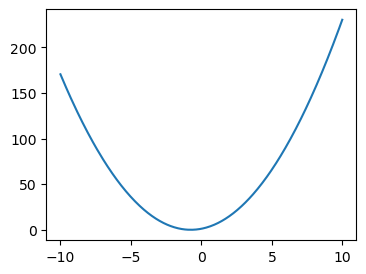

In [2]:
# 데이터 생성
x_train, y_train = generate_data()

plt.figure(figsize=(4, 3))
plt.plot(x_train.numpy(), y_train.numpy())
plt.show()

In [3]:
# 신경망 모델 정의
class QuadraticNet(nn.Module):
    def __init__(self):
        super(QuadraticNet, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # x = self.fc1(x)
        # x = self.fc2(x)
        x = self.fc3(x)
        return x

### 메모리 체크

In [4]:
# 모델 초기화
initial_memory = torch.cuda.memory_allocated()
print(f"초기 GPU 메모리 사용량: {initial_memory / 1024**2:.4f} MB")

초기 GPU 메모리 사용량: 0.0000 MB


In [5]:
# # 모델 초기화
# initial_memory = torch.cuda.memory_allocated()
# print(f"초기 GPU 메모리 사용량: {initial_memory / 1024**2:.4f} MB")
model = QuadraticNet().cuda()
memory_model = torch.cuda.memory_allocated()
print(f"모델 GPU 메모리 사용량: {(memory_model - initial_memory) / 1024**2:.4f} MB")

모델 GPU 메모리 사용량: 0.0103 MB


#### sample param, grad

In [6]:
sample_param = next(model.parameters())

In [7]:
epochs=10000
lr=0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

x_train = x_train.cuda()
y_train = y_train.cuda()
losses = []

memory_data = torch.cuda.memory_allocated()
print(f"Dataset GPU 메모리 사용량: {(memory_data - initial_memory) / 1024**2:.4f} MB")

for epoch in range(epochs):
    optimizer.zero_grad()
    memory_start = torch.cuda.memory_allocated()
    outputs = model(x_train)
    if epoch==0:#<=1
        memory = torch.cuda.memory_allocated()
        print(f"Forward GPU 메모리 사용량: {(memory - memory_start) / 1024**2:.4f} MB")
    loss = criterion(outputs, y_train)
    loss.backward()
    if epoch==0:#<=1
        memory = torch.cuda.memory_allocated()
        print(f"Backward GPU 메모리 사용량: {(memory - memory_start) / 1024**2:.4f} MB")
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    losses.append(loss.item())

Dataset GPU 메모리 사용량: 0.0181 MB
Forward GPU 메모리 사용량: 8.4951 MB
Backward GPU 메모리 사용량: 16.2681 MB
Epoch [100/10000], Loss: 339.4589
Epoch [200/10000], Loss: 39.3212
Epoch [300/10000], Loss: 3.6957
Epoch [400/10000], Loss: 0.7993
Epoch [500/10000], Loss: 0.2941
Epoch [600/10000], Loss: 0.1470
Epoch [700/10000], Loss: 0.3452
Epoch [800/10000], Loss: 0.1550
Epoch [900/10000], Loss: 0.0902
Epoch [1000/10000], Loss: 0.1154
Epoch [1100/10000], Loss: 0.1269
Epoch [1200/10000], Loss: 0.1625
Epoch [1300/10000], Loss: 0.0283
Epoch [1400/10000], Loss: 0.0236
Epoch [1500/10000], Loss: 0.0223
Epoch [1600/10000], Loss: 0.7151
Epoch [1700/10000], Loss: 0.0196
Epoch [1800/10000], Loss: 0.0197
Epoch [1900/10000], Loss: 0.0183
Epoch [2000/10000], Loss: 0.0187
Epoch [2100/10000], Loss: 0.0272
Epoch [2200/10000], Loss: 0.0162
Epoch [2300/10000], Loss: 0.0164
Epoch [2400/10000], Loss: 0.0517
Epoch [2500/10000], Loss: 0.1762
Epoch [2600/10000], Loss: 0.0854
Epoch [2700/10000], Loss: 0.0803
Epoch [2800/10000], 

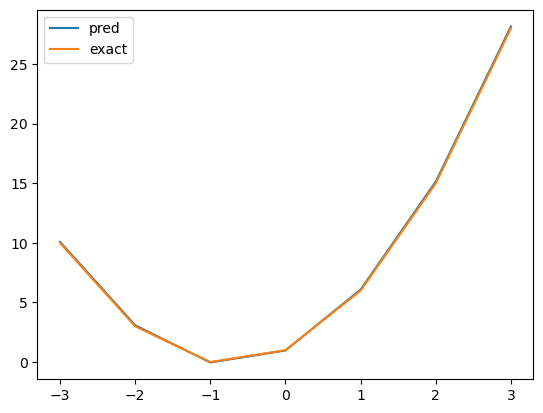


테스트 예측 결과:
x = -3.0, 예측값 = 10.08, 실제값 = 10.00
x = -2.0, 예측값 = 3.08, 실제값 = 3.00
x = -1.0, 예측값 = -0.03, 실제값 = 0.00
x = 0.0, 예측값 = 0.97, 실제값 = 1.00
x = 1.0, 예측값 = 6.08, 실제값 = 6.00
x = 2.0, 예측값 = 15.14, 실제값 = 15.00
x = 3.0, 예측값 = 28.15, 실제값 = 28.00


In [8]:
# 학습된 모델의 예측 예시
test_x = torch.FloatTensor([-3, -2, -1, 0, 1, 2, 3]).view(-1, 1).cuda()
exact_y = 2 * test_x**2 + 3 * test_x + 1
with torch.no_grad():
    test_y = model(test_x)
    plt.plot(test_x.cpu(), test_y.cpu(), label='pred')
    plt.plot(test_x.cpu(), exact_y.cpu(), label='exact')
    plt.legend()
    plt.show()
    print("\n테스트 예측 결과:")
    for x, y, y_answer in zip(test_x, test_y, exact_y):
        print(f"x = {x.item():.1f}, 예측값 = {y.item():.2f}, 실제값 = {y_answer.item():.2f}")